In [1839]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import seaborn as sns

# Regression lineaire
from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import het_white , normal_ad
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

import statsmodels.api as sm
# Regression logistique
from statsmodels.api import Logit
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import roc_auc_score , roc_curve, accuracy_score , precision_score, recall_score

from scipy.stats import t, shapiro
# k_means
from sklearn import decomposition
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


# Exploration

In [1840]:
Billets_df = pd.read_csv('billets.csv', sep=";")


In [1841]:
# Resume des donnees brutes:
Billets_df.info()
Billets_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000000,1500.000000,1500.000000,1463.000000,1500.000000,1500.00000
mean,171.958440,104.029533,103.920307,4.485967,3.151473,112.67850
std,0.305195,0.299462,0.325627,0.663813,0.231813,0.87273
min,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,171.750000,103.820000,103.710000,4.015000,2.990000,112.03000
50%,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000
max,173.010000,104.880000,104.950000,6.900000,3.910000,114.44000


Il manque 37 valeurs dans margine_low.

In [1842]:
#Verification des valeurs manquantes
print(Billets_df.index[Billets_df.isnull().any(axis=1)])
print(Billets_df.isna().sum())

Int64Index([  72,   99,  151,  197,  241,  251,  284,  334,  410,  413,  445,
             481,  505,  611,  654,  675,  710,  739,  742,  780,  798,  844,
             845,  871,  895,  919,  945,  946,  981, 1076, 1121, 1176, 1303,
            1315, 1347, 1435, 1438],
           dtype='int64')
is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64


# Regression lineaire

La régression linéaire est une méthode statistique qui permet de modéliser la relation entre deux variables quantitatives, en supposant qu'elles sont linéairement liées. Plus précisément, elle permet de prédire la valeur d'une variable dépendante (aussi appelée variable cible) en fonction de la valeur d'une variable indépendante (aussi appelée variable explicative).  
 Nous pourrions recourir à une régression linéaire pour estimer les valeurs manquantes de "margin_low"(variable dépendante).

In [1843]:

# Separation des donnees manquantes :
Reg_Lin_Train_df = Billets_df.dropna() 
Reg_Lin_Test_df = Billets_df[Billets_df.isnull().any(axis=1)] #Remplacer les valeurs manquantes par NaN

# Creation de X_train et Y_train: Separation des variable dependante et independadnte
x_train = Reg_Lin_Train_df.drop(columns=['margin_low', 'is_genuine'] ) 
y_train = Reg_Lin_Train_df["margin_low"]

# Regression lineaire:
reg_lin = LinearRegression()
#entrainement du modèle
model_reg_lin = reg_lin.fit(x_train, y_train)

# Predictions:

Reg_Lin_Train_df["margin_low_pred"] = reg_lin.predict(x_train)


/var/folders/l3/vqrln6517tl991tlswjqjnb80000gn/T/ipykernel_47601/1400941990.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Reg_Lin_Train_df["margin_low_pred"] = reg_lin.predict(x_train)


In [1844]:


print("Intercept: %.2f" % model_reg_lin.intercept_)
print("Coéfficients:" , model_reg_lin.coef_)
y= Reg_Lin_Train_df["margin_low"] 
y_predicted= Reg_Lin_Train_df["margin_low_pred"] 

# RMSE

rmse = (np.sqrt(mean_squared_error(y, y_predicted)))
print("RMSE= %.2f"% rmse)

display(Reg_Lin_Train_df[:3])
#print(y.mean())



Intercept: 22.99
Coéfficients: [-0.11105978  0.18412242  0.25713805  0.2561879  -0.40910293]
RMSE= 0.48


,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,margin_low_pred
0,True,171.81,104.86,104.95,4.52,2.89,112.83,4.788676
1,True,171.46,103.36,103.66,3.77,2.99,113.09,4.138908
2,True,172.69,104.48,103.50,4.40,2.94,113.16,4.125933


La valeur de intercept est la valeur moyenne estimée de notre variable dépendante lorsque toutes les valeurs des variables indépendantes sont égales à 0. En d'autres termes, l'intercept représente la valeur de départ de la relation linéaire entre les variables.  
  
Les coef indique dans quelle mesure la valeur de la variable dépendante varie avec la variation de la valeur de la variable explicative. 
  
La RMSE, ou racine des erreurs quadratique moyenne. Elle s’exprime dans la même unité que la variable à prédire et est par conséquent plus facile à interpréter.


In [1845]:
# Instanciation:

reg_multi = smf.ols('margin_low~+height_left+diagonal+height_right+margin_up+length', data=Billets_df).fit()
print(reg_multi.summary())


                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     266.1
Date:                Thu, 25 May 2023   Prob (F-statistic):          2.60e-202
Time:                        21:25:27   Log-Likelihood:                -1001.3
No. Observations:                1463   AIC:                             2015.
Df Residuals:                    1457   BIC:                             2046.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       22.9948      9.656      2.382   

Méthode des moindres carrés :  
Le R² : il s'agit de la proportion de la variance de la variable dépendante qui peut être expliquée par une ou plusieurs variables indépendantes. Un R² proche de 0,50 indique que la moitié de la variation observée dans le modèle peut être expliquée par les points.
  
Probabilité F-statistique : elle indique la signification globale de la régression en évaluant le niveau de signification de toutes les variables ensemble. L'hypothèse nulle est que tous les coefficients de régression sont égaux à zéro. Si cette probabilité est très faible et proche de 0, on rejette l'hypothèse nulle, ce qui signifie que le modèle est meilleur que celui où les coefficients seraient égaux à 0.  
  


Les coefficients : ils représentent le changement moyen de la variable dépendante pour une unité de changement dans la variable indépendante, tout en maintenant les autres variables indépendantes constantes. Ainsi, si la variable "length" change d'une unité (1 mm), l'estimation de "margin_low" diminuera en moyenne de 0,4091 mm.

### Analyse des residus:
Analyse des résidus :
Normalité de la distribution des résidus : le test omnibus a pour hypothèse nulle que les résidus sont distribués selon une loi normale. Si la valeur de la probabilité est proche de 1, cette hypothèse est vérifiée. Si elle est nulle, cela signifie que l'hypothèse n'est pas vérifiée et que les coefficients estimés ne seront pas les meilleurs coefficients linéaires non biaisés (BLUE). Le test de Jarque-Bera est redondant avec le test omnibus, mais une valeur élevée pour le Jarque-Bera indique que les résidus sont distribués selon une loi normale. Pour confirmer cela, on peut effectuer un test d'Anderson-Darling.

Non-autocorrélation : le test de Durbin-Watson permet de tester l'autocorrélation des résidus dans le temps. L'hypothèse nulle stipule qu'il n'y a pas d'autocorrélation. Si la statistique a une valeur proche de 2, on retient l'hypothèse nulle. Ici, nous avons une valeur de 1,9.


Le test de la moyenne nulle des résidus est utilisé pour évaluer si les résidus d'un modèle de régression ont une moyenne statistiquement différente de zéro. 
-0.00000000000009 étant très proches de zéro, on peut considérer cette hypothèse comme validée.  
 Une moyenne des résidus nulle indique que les prédictions sont en moyenne très proches des valeurs réelles

In [1846]:
#hypothese des moyennes nulle des residus
reg_multi.resid.mean()

9.614910826960153e-14

 p-value du test d'Aderson-Darling : 5.114137678791534e-12


/var/folders/l3/vqrln6517tl991tlswjqjnb80000gn/T/ipykernel_47601/3111144709.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Reg_Lin_Train_df["residual"] = Reg_Lin_Train_df["margin_low"] - Reg_Lin_Train_df["margin_low_pred"]


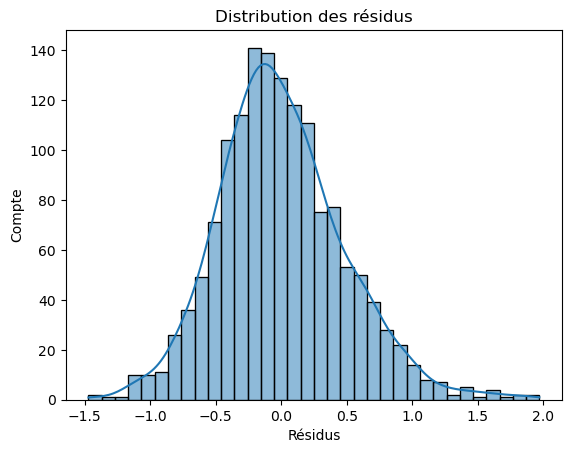

In [1847]:
# Creation d'une colonne contenant les residus:
Reg_Lin_Train_df["residual"] = Reg_Lin_Train_df["margin_low"] - Reg_Lin_Train_df["margin_low_pred"]
# Normalite:
print(" p-value du test d'Aderson-Darling :", normal_ad(Reg_Lin_Train_df["residual"])[1])

# Graphique:
sns.histplot(Reg_Lin_Train_df["residual"], kde=True)
plt.xlabel("Résidus")
plt.ylabel("Compte")
plt.title("Distribution des résidus")
plt.show()

p_value < 0,05
 l'hypothèse n'est pas rejetée puisque la p-value obtenue est inférieure au seuil 0,05, les résidus suivent une distribution Normale.

In [1848]:


# Sélection des colonnes à standardiser et à utiliser pour le calcul du VIF
cols_to_vif = ["diagonal", "height_left", "height_right", "margin_up", "length"]
Reg_Lin_Train_df2 = Billets_df.dropna()
#print(Billets_df)
# Création d'un objet StandardScaler
#scaler = StandardScaler()

# Standardisation des colonnes sélectionnées
#Reg_Lin_Train_df2[cols_to_vif] = scaler.fit_transform(Reg_Lin_Train_df2[cols_to_vif])

# Calcul des VIF pour les colonnes sélectionnées
vif = pd.Series([variance_inflation_factor(Reg_Lin_Train_df2[cols_to_vif].values, i)
                 for i in range(len(cols_to_vif))], 
                index=cols_to_vif)
print(Reg_Lin_Train_df2[cols_to_vif])
# Affichage des résultats
print("VIF par feature:\n", vif)
print("VIF moyen:", vif.mean())

      diagonal  height_left  height_right  margin_up  length
0       171.81       104.86        104.95       2.89  112.83
1       171.46       103.36        103.66       2.99  113.09
2       172.69       104.48        103.50       2.94  113.16
3       171.36       103.91        103.94       3.01  113.51
4       171.73       104.28        103.46       3.48  112.54
...        ...          ...           ...        ...     ...
1495    171.75       104.38        104.17       3.09  111.28
1496    172.19       104.63        104.44       3.37  110.97
1497    171.80       104.01        104.12       3.36  111.95
1498    172.06       104.28        104.06       3.46  112.25
1499    171.47       104.15        103.82       3.37  112.07

[1463 rows x 5 columns]
VIF par feature:
 diagonal        170566.670778
height_left     111895.309916
height_right    100858.864433
margin_up          261.969190
length           22708.222743
dtype: float64
VIF moyen: 81258.20741161003


Multicollinéarité :  Le VIF indique  une faible multicolinéarité.

{'Test Statistic': 109.86015196915031, 'p-value': 2.0828244985524268e-14, 'F-Statistic': 5.853731207829417, 'F-Test p-value': 4.974865091603998e-15}


Text(0.5, 1.0, 'Homoscédasticité')

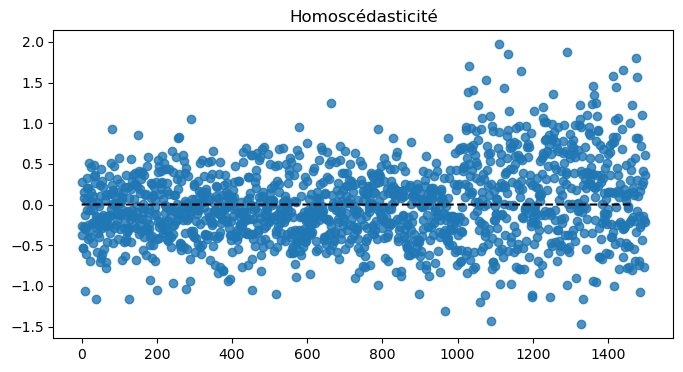

In [1849]:
# Homoscedasticite:
white_test = het_white(reg_multi.resid, reg_multi.model.exog)
labels_white_test = ["Test Statistic", "p-value", "F-Statistic", "F-Test p-value"]
print(dict(zip(labels_white_test, white_test)))

# Graphique:
plt.subplots(figsize=(8, 4))
plt.scatter(x=Reg_Lin_Train_df.index, y=Reg_Lin_Train_df["residual"], alpha=0.8)
plt.plot(np.repeat(0, len(Reg_Lin_Train_df.index)+2), color="black", linestyle='--')
plt.title("Homoscédasticité")

Homoscedasticité: (Uniformité de la variance de l’erreur dans un ensemble de valeurs observées.)
Le test retenu est celui de White dont l’hypothèse nulle est l’homoscédasticité des résidus.
(la variance d'un individu à un autre est constante) On fixe un seuil alpha de 5 %.
La p-value est ici très inférieure au seuil,l'hypothèse d'homoscédasticité de notre régression linéaire est donc considérée comme vérifiée au risque alpha 5 % 

In [1850]:
#les résidus studentisés doivent rester comprise entre −2 et 2.
# Identification des individus atypiques et influents (iai):

alpha = 0.05
n = 1463
p = 5

analyses = pd.DataFrame({'obs':np.arange(1, n+1)})
#print(analyses)

analyses['levier'] = reg_multi.get_influence().hat_matrix_diag

seuil_levier = 2*p/n
print(analyses)



       obs    levier
0        1  0.016606
1        2  0.006015
2        3  0.008298
3        4  0.004467
4        5  0.005558
...    ...       ...
1458  1459  0.004307
1459  1460  0.005672
1460  1461  0.001643
1461  1462  0.002254
1462  1463  0.003324

[1463 rows x 2 columns]


In [1851]:
analyses.loc[analyses['levier'] > seuil_levier, :]


analyses['rstudent'] = reg_multi.get_influence().resid_studentized_internal
seuil_rstudent = t.ppf(1-alpha/2,n-p-1)

print(seuil_rstudent)

1.9615935038492915


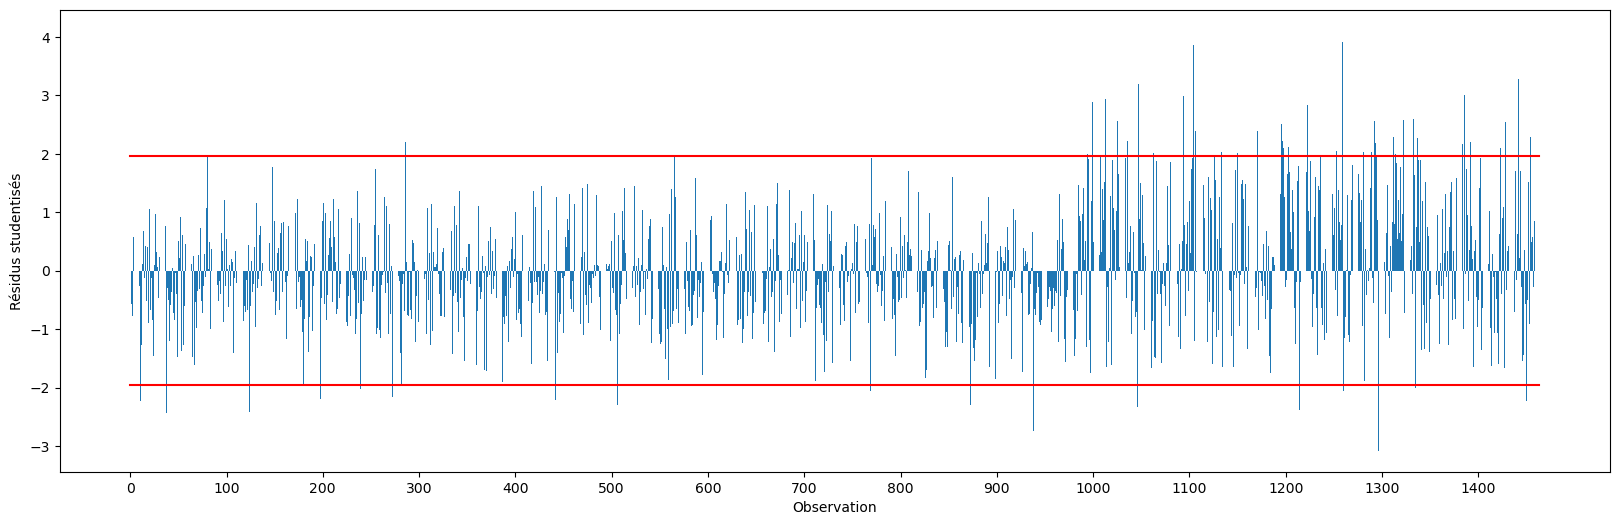

      rstudent
10   -2.221047
37   -2.426466
123  -2.414722
197  -2.189564
238  -2.018889
...        ...
1427  2.548894
1436  3.741140
1441  3.280337
1449 -2.232347
1453  2.285591

[78 rows x 1 columns]


In [1852]:
#individus influent superieur a 2 ou inferieur a -2 

plt.figure(figsize=(20,6))
plt.bar(analyses['obs'], analyses['rstudent'])
plt.xticks(np.arange(0, 1463, step=100))
plt.xlabel('Observation')
plt.ylabel('Résidus studentisés')
plt.plot([0, 1463], [seuil_rstudent, seuil_rstudent], color='r')
plt.plot([0, 1463], [-seuil_rstudent, -seuil_rstudent], color='r')
plt.show()

#[abs(iai_df["leverage"]) > lev_thr]
influentdf= pd.DataFrame(analyses["rstudent"] )  
influentdf = influentdf.loc[abs(influentdf["rstudent"]) >(seuil_rstudent)] # on ne garde que les valeur influente (78)
#influentdf = influentdf +influentdf.loc[influentdf["rstudent"] <-2]
print(influentdf)


       obs    levier  rstudent
0        1  0.016606 -0.563593
1        2  0.006015 -0.769710
2        3  0.008298  0.572488
3        4  0.004467 -1.118681
4        5  0.005558 -1.121058
...    ...       ...       ...
1458  1459  0.004307 -1.608823
1459  1460  0.005672 -0.389864
1460  1461  0.001643  1.269372
1461  1462  0.002254  0.752677
1462  1463  0.003324 -0.435548

[1463 rows x 3 columns]


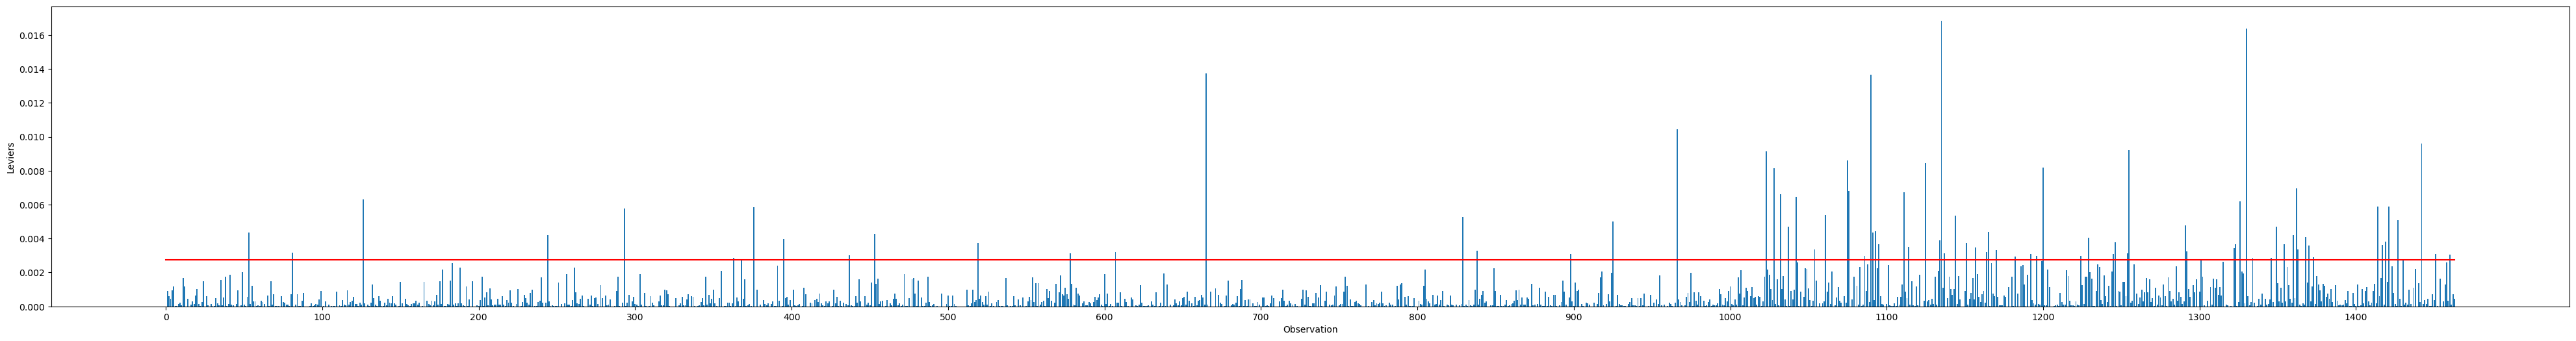

      dcooks
52      True
80      True
125     True
243     True
292     True
...      ...
1420    True
1426    True
1441    True
1450    True
1459    True

[80 rows x 1 columns]


In [1853]:
# Calcul de la distance de cook pour identifier les valeurs atypique
influence = reg_multi.get_influence().summary_frame() # donner studentiser + residu +cook_d + hat_diag
#print(influence)
print(analyses)
# analyse df = levier + dcooks _ rstudent
analyses['dcooks'] = influence['cooks_d']

seuil_dcook = 4/(n-p)

plt.figure(figsize=(50,6))
plt.bar(analyses['obs'], analyses['dcooks'])
plt.xticks(np.arange(0, 1463, step=100))
plt.xlabel('Observation')
plt.ylabel('Leviers')
plt.plot([0, 1463], [seuil_dcook, seuil_dcook], color='r')
plt.show()
atypdf= pd.DataFrame(analyses["dcooks"] >= seuil_dcook )
atypdf = atypdf.loc[atypdf["dcooks"] == True]

print(atypdf)

In [1854]:
outliers_hg_lev =pd.merge(influentdf,atypdf, left_index=True, right_index=True)
print(outliers_hg_lev.count())
print(outliers_hg_lev)

rstudent    5
dcooks      5
dtype: int64
      rstudent  dcooks
1031 -2.510481    True
1195  2.504636    True
1291  2.564383    True
1321  2.582140    True
1441  3.280337    True


 On peut remarquer qu'il y a un certain nombre d'individus a forte influence.  
  Ces individus sont représentés par des points situés en haut du graphique >2, avec des résidus studentisés élevés. Il y a également des points situés en bas du graphique avec des résidus studentisés  bas <2. Ces individus sont également considérés comme atypiques.
   Les individus atypiques et influents peuvent avoir un impact  sur la qualité de la modélisation, il faudrat le verifier.

78 individus influents (residus studentidé) > 2.

Il y a 80 individus atypique.  
Il faut donc comparer les individus atypiques et influents pour identifier les individus ayant un impact sur la régression linéaire.

Il y a donc 5 individus atypique et influent. on les supprime et on relance la regression pour voir le changement.

In [1855]:
# Suppression des IAI: 
Billet_sans_iai_df = Billets_df.drop(outliers_hg_lev.index)

print(Billet_sans_iai_df.count())
# Instanciation:
reg_lin_c = smf.ols("margin_low ~ diagonal + height_left + height_right + margin_up + length", data = Billet_sans_iai_df)

# Calculs:
model_reg_lin_b = reg_lin_c.fit()
print(model_reg_lin_b.summary())

is_genuine      1495
diagonal        1495
height_left     1495
height_right    1495
margin_low      1458
margin_up       1495
length          1495
dtype: int64
                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.481
Model:                            OLS   Adj. R-squared:                  0.479
Method:                 Least Squares   F-statistic:                     268.7
Date:                Thu, 25 May 2023   Prob (F-statistic):          1.36e-203
Time:                        21:25:31   Log-Likelihood:                -983.14
No. Observations:                1458   AIC:                             1978.
Df Residuals:                    1452   BIC:                             2010.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t     

Après avoir vérifié l'impact des individus atypiques et à forte influence sur notre modèle, nous pouvons constater que cet impact est très faible.

In [1856]:
# Application du modele sur les donnees test
x_test = Reg_Lin_Test_df[["diagonal","height_left","height_right", "margin_up","length"]]

Reg_Lin_Test_df["margin_low"] = reg_lin.predict(x_test)
# Concatenation:

reg_lin_result = [Reg_Lin_Test_df, Reg_Lin_Train_df]
Billet_df = pd.concat(reg_lin_result)


Billet_df = Billet_df.drop(["margin_low_pred", "residual"], axis=1)

Billet_df.describe()



/var/folders/l3/vqrln6517tl991tlswjqjnb80000gn/T/ipykernel_47601/1331811293.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Reg_Lin_Test_df["margin_low"] = reg_lin.predict(x_test)


,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.00000
mean,171.958440,104.029533,103.920307,4.483475,3.151473,112.67850
std,0.305195,0.299462,0.325627,0.659632,0.231813,0.87273
min,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,171.750000,103.820000,103.710000,4.020000,2.990000,112.03000
50%,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000
max,173.010000,104.880000,104.950000,6.900000,3.910000,114.44000


En observant la colonne "margin_low", il apparaît que la complétion des valeurs manquantes n'a pas un impact significatif sur les résultats.

# Analyse exploratoire

            diagonal  height_left  height_right  margin_low  margin_up  length
is_genuine                                                                    
False            500          500           500         500        500     500
True            1000         1000          1000        1000       1000    1000


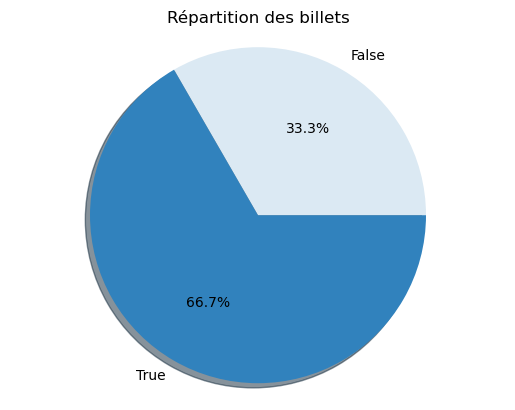

In [1857]:
# Repartition des vrais/faux billets dans notre dataset d'apprentissage:
print(Billet_df.groupby(["is_genuine"]).count())

# Graphique:
fig1, ax1 = plt.subplots()
ax1.pie(Billet_df.groupby(["is_genuine"])["diagonal"].count(),
        labels=["False","True"],
        autopct="%1.1f%%",
        colors=["#dbe9f3","#3182bd"],
        shadow=True)
ax1.axis("equal")
plt.title("Répartition des billets")
plt.show()

Notre jeu de donnée contient 1500 billets  
500 Billets sont faux (soit 33,3% de notre jeu de donnée)  
1000 Billet sont vraix (66,7%).  


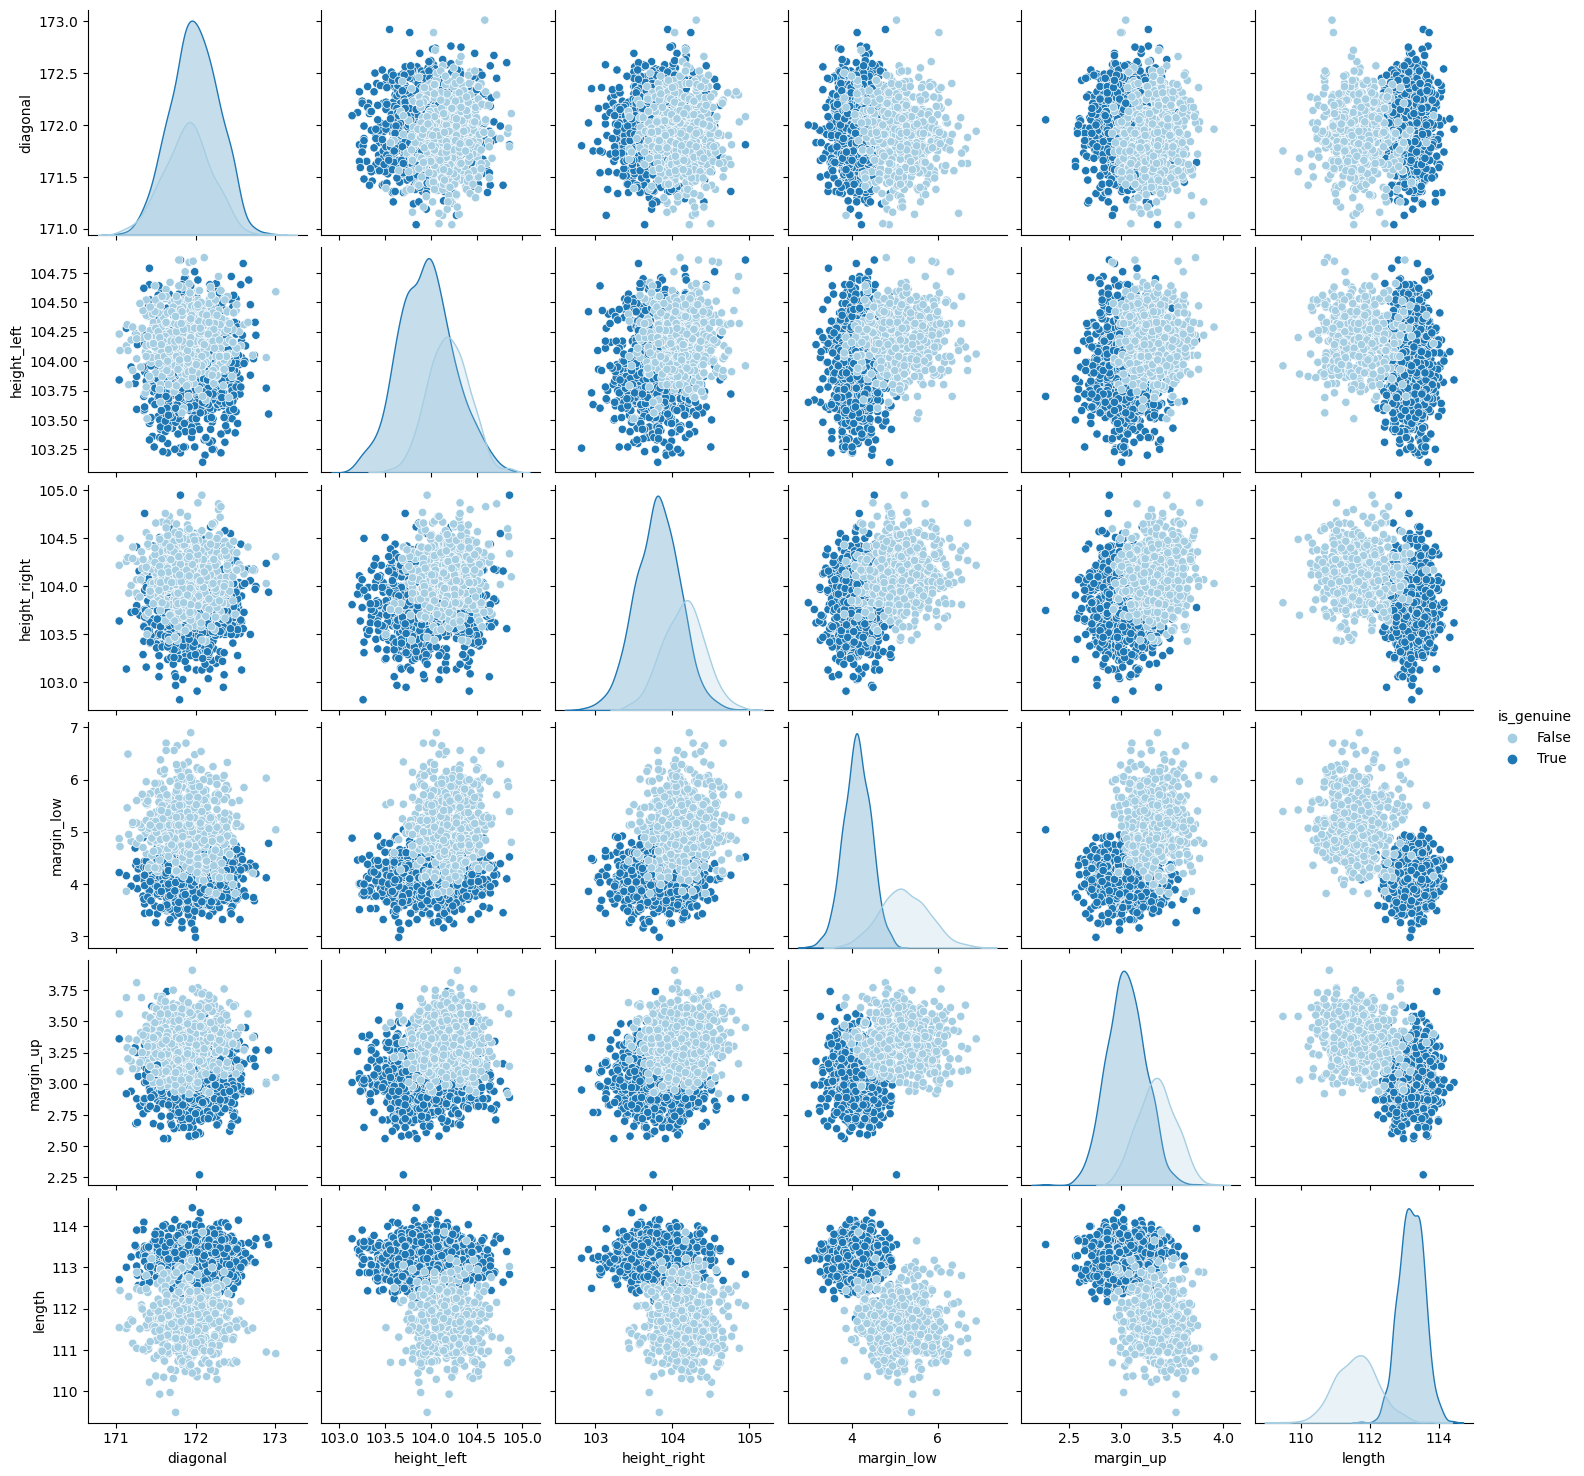

In [1858]:
# Pair plot:
sns.pairplot(Billets_df, hue="is_genuine", palette="Paired")

Ce graphique nous permet de considérer rapidement que margin_low et length sont les deux observations qui on l'air d'avoir le plus d'incidence sur " is_genuine"

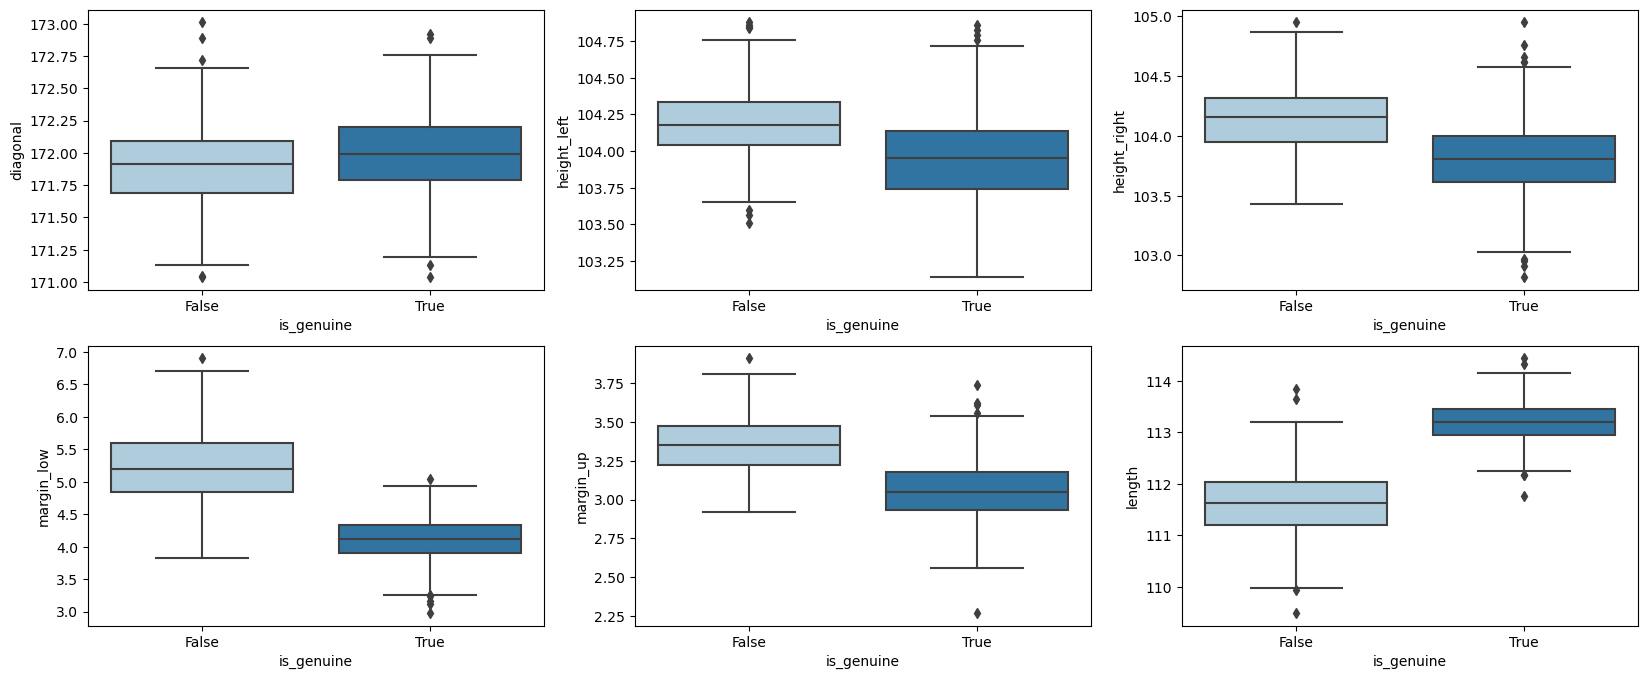

In [1859]:
a = 2  # nombre de lignes
b = 3  # nombre de colonnes
c = 1  # initialisation

fig = plt.figure(figsize=(20,8))

for i in Billets_df.loc[:, Billets_df.columns != "is_genuine"]:
    plt.subplot(a, b, c)
    #plt.title('{} (boxplot)'.format(i, a, b, c))
    plt.xlabel(i)
    sns.boxplot(x= Billets_df["is_genuine"],y = Billets_df[i], palette= "Paired")
    c = c + 1
plt.show()

Text(0.5, 1.0, 'corrélations des variables')

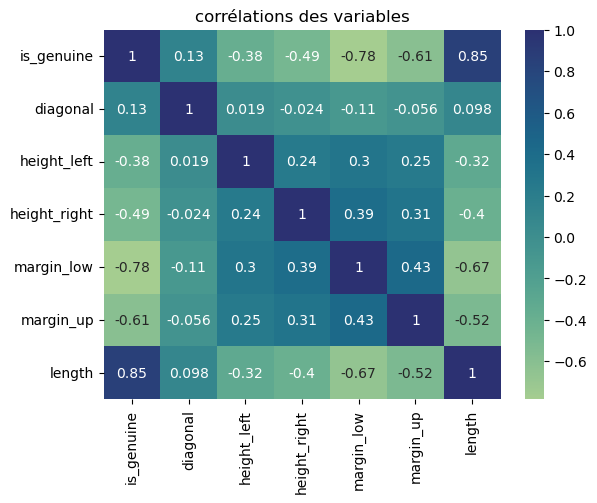

In [1860]:
# Heatmap de correlations des variables
c = sns.color_palette("crest", as_cmap=True)
sns.heatmap(Billets_df.corr(), annot=True ,cmap= c).set_title('corrélations des variables')

La matrice de correlation confirme nos hypothèses précédentes:  

is_genuine est très fortement correlé à length (0.85)  
is_genuine est  fortement anticorrelé à margin_low (-0.78)  


Cetains point sont élognés de leur groupe: Faire un box plot de chaques variable 

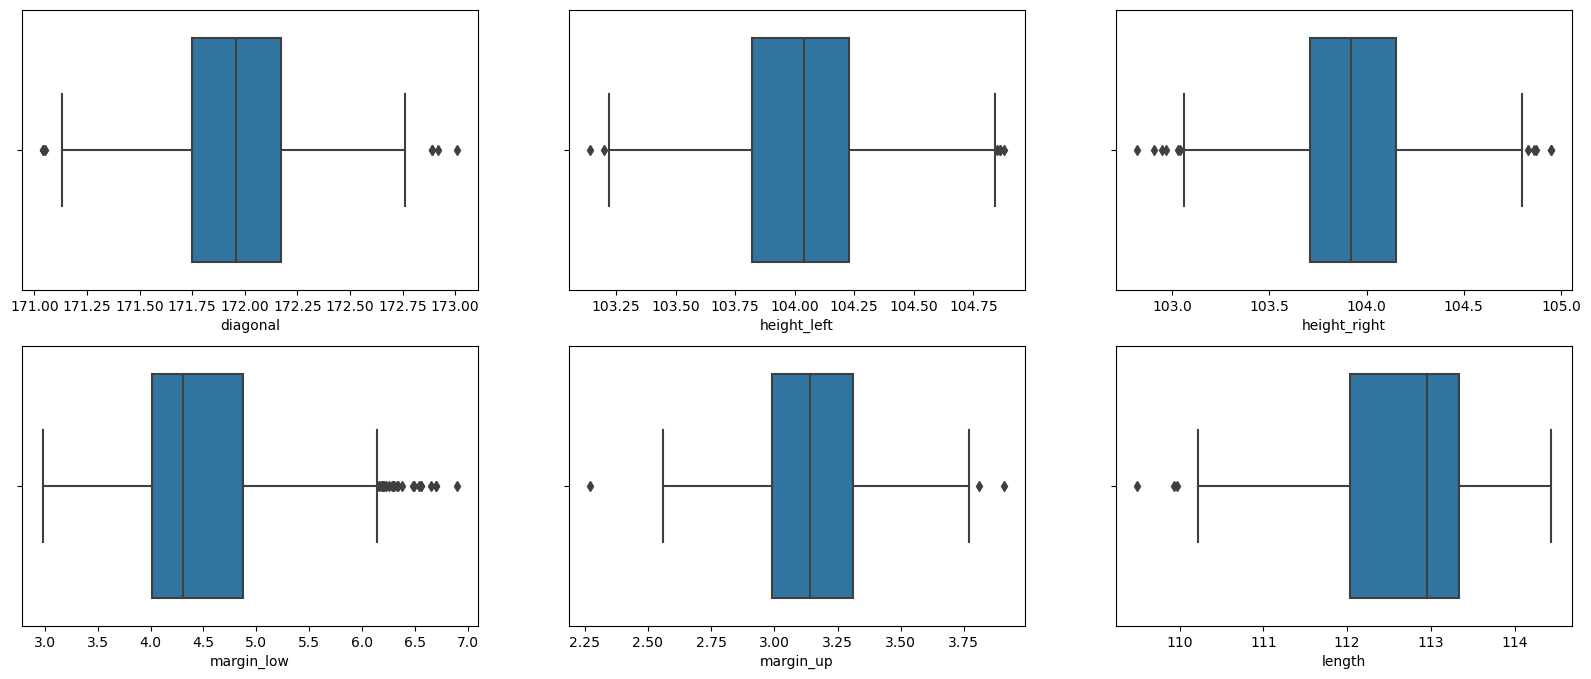

In [1861]:
# Representation graphique des outliers:
a = 2  # nombre de lignes
b = 3  # nombre de colonnes
c = 1  # initialisation

fig = plt.figure(figsize=(20,8))

for i in Billets_df.loc[:, Billets_df.columns != "is_genuine"]:
    plt.subplot(a, b, c)
    #plt.title('{} (boxplot)'.format(i, a, b, c))
    plt.xlabel(i)
    sns.boxplot(x = Billets_df[i])
    c = c + 1
plt.show()

Comme nous l'avons vu lors de la recherche d'individus atypiques, il y a des outliers

# Regression logistique

Nous souhaitons créer un modèle prédictif basé sur des données annotées pour expliquer une variable qualitative binaire (Vrai/faux) en utilisant des variables  quantitatives (mesures en millimètre). Pour cela, nous avons besoin de mettre en place une régression logistique en isolant la variable cible des autres.

La régression logistique nécessite les conditions suivantes:

- La variable dépendante doit être binaire.  
- Seules les variables significatives doivent être incluses.  
- Les variables indépendantes doivent être indépendantes les unes des autres, sans multicollinéarité significative.  
- La régression logistique nécessite un échantillon de taille suffisamment grande.  

In [1862]:

#y_billet : DF avec la variable dependante
# y (authenticite): 
y_billet = Billet_df.loc[:, Billet_df.columns == "is_genuine"]
print(y_billet.value_counts())                                  

# X (les autres): 
X_billet = Billet_df.loc[:, Billet_df.columns != "is_genuine"]
X_billet = sm.tools.add_constant(X_billet)                      #Il faut ajouter une constante dans Statsmodels
print(X_billet.head())


is_genuine
True          1000
False          500
dtype: int64
     const  diagonal  height_left  height_right  margin_low  margin_up  length
72     1.0    171.94       103.89        103.45    4.318525       3.25  112.79
99     1.0    171.93       104.07        104.18    4.393668       3.14  113.08
151    1.0    172.07       103.80        104.38    4.410457       3.02  112.93
197    1.0    171.45       103.66        103.80    4.319014       3.62  113.27
241    1.0    171.83       104.14        104.06    4.650617       3.02  112.36


In [1863]:
# Regression logistique:
reg_log = Logit(endog=y_billet,exog=X_billet)

# Calculs:
res_log = reg_log.fit()

# Resume des resultats:
print(res_log.summary2())

Optimization terminated successfully.
         Current function value: 0.028228
         Iterations 13
                         Results: Logit
Model:                Logit            Pseudo R-squared: 0.956   
Dependent Variable:   is_genuine       AIC:              98.6848 
Date:                 2023-05-25 21:25 BIC:              135.8773
No. Observations:     1500             Log-Likelihood:   -42.342 
Df Model:             6                LL-Null:          -954.77 
Df Residuals:         1493             LLR p-value:      0.0000  
Converged:            1.0000           Scale:            1.0000  
No. Iterations:       13.0000                                    
-----------------------------------------------------------------
               Coef.   Std.Err.    z    P>|z|    [0.025   0.975] 
-----------------------------------------------------------------
const        -204.5582 241.7683 -0.8461 0.3975 -678.4154 269.2990
diagonal        0.0680   1.0913  0.0623 0.9503   -2.0708   2.2068


Il y a des variables x non-significatives .

In [1864]:
# On ne garde que les variables significatives a alpha = 5% dans X_Billet:
X_billet = Billet_df[["height_right","margin_low", "margin_up", "length"]]
X_billet = sm.add_constant(X_billet)

# On recommence la regression logistique:
reg_log = Logit(endog=y_billet,exog=X_billet)

# Creation du modele:
model_reg_log = reg_log.fit()

# Resume des resultats:
print(model_reg_log.summary2())

Optimization terminated successfully.
         Current function value: 0.029058
         Iterations 12
                         Results: Logit
Model:                Logit            Pseudo R-squared: 0.954   
Dependent Variable:   is_genuine       AIC:              97.1726 
Date:                 2023-05-25 21:25 BIC:              123.7387
No. Observations:     1500             Log-Likelihood:   -43.586 
Df Model:             4                LL-Null:          -954.77 
Df Residuals:         1495             LLR p-value:      0.0000  
Converged:            1.0000           Scale:            1.0000  
No. Iterations:       12.0000                                    
-----------------------------------------------------------------
               Coef.   Std.Err.    z    P>|z|    [0.025   0.975] 
-----------------------------------------------------------------
const        -323.4452 139.5320 -2.3181 0.0204 -596.9229 -49.9675
height_right   -2.7839   1.0779 -2.5827 0.0098   -4.8965  -0.6712

Tests statistique de la regression logistique.  
    - La taille de l'echantillon: doit etre superieur a 500. ici elle est de 1500 dont 500 faux billets.  
    -Significativité des variables : seules les variables significatives sont incluses. seul les variable avec une p-value significative ont été conservé.  
    - Indépendance des observations : les observations sont indépendantes : ici, c'est le cas, chaque billets étant uniques et indépendants des autres.  
    -Multicollinéarité : Test avec VIF (variance inflation factor).  
    - Les coefficients mesurent l'impact de chaque variable indépendante sur la variable dépendante, en tenant compte des autres variables du modèle.
    

In [1865]:
# Multicollinearite:
vif= pd.Series([variance_inflation_factor(X_billet.values, i)
               for i in range(X_billet.shape[1])],
              index=X_billet.columns)
print("VIF par features:\n", vif)
print("VIF moyen:",vif.mean())

VIF par features:
 const           185216.418668
height_right         1.246905
margin_low           1.906386
margin_up            1.411962
length               2.113826
dtype: float64
VIF moyen: 37044.61954940248


Aucune des variables n'a de VIF supérieur à 2,5. Il n'y a donc pas de collinéarité

In [1866]:
Billet_df["proba"] = model_reg_log.predict(X_billet)
Billet_df["y_pred"] = (model_reg_log.predict(X_billet) >= 0.5).astype(int)
Billet_df.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,proba,y_pred
72,True,171.94,103.89,103.45,4.318525,3.25,112.79,0.985560,1
99,True,171.93,104.07,104.18,4.393668,3.14,113.08,0.990014,1
151,True,172.07,103.80,104.38,4.410457,3.02,112.93,0.986159,1
197,True,171.45,103.66,103.80,4.319014,3.62,113.27,0.912214,1
241,True,171.83,104.14,104.06,4.650617,3.02,112.36,0.574696,1


## Evaluation du modele

[[32.8         0.53333333]
 [ 0.2        66.46666667]]


Text(0.5, 1.0, 'Matrice de confusion de la régression logistique\n')

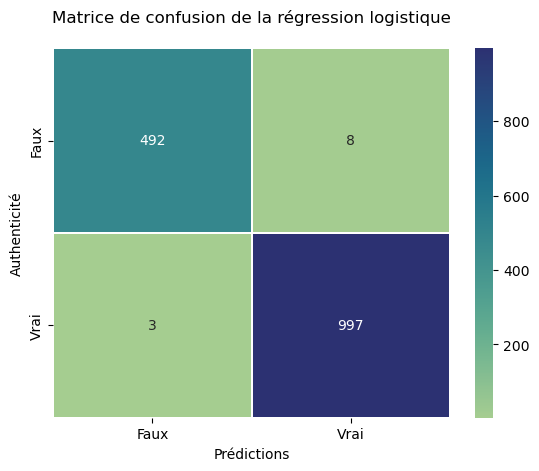

In [1867]:
# Matrice de confusion:
conf_matrix_reg_log = model_reg_log.pred_table()
prct = (conf_matrix_reg_log*100)/n_reg_lin
print(prct)

# Graphique:
sns.heatmap(conf_matrix_reg_log,
            annot = True,
            fmt = ".3g", 
            cmap = sns.color_palette("crest", as_cmap=True),
            linecolor = "white",
            linewidths = 0.3,
            xticklabels = ["Faux","Vrai"],
            yticklabels=["Faux","Vrai"]
            )
plt.xlabel("Prédictions")
plt.ylabel("Authenticité")
plt.title("Matrice de confusion de la régression logistique\n")

8 billets sur les 500 faux billet on étés predits comme vrais.  
3 billets sur les 1000 vrais billets on étés predit comme faux.

In [1868]:
print("Précision:",accuracy_score(Billet_df["is_genuine"], Billet_df["y_pred"]))
print("Spécificité:",precision_score(Billet_df["is_genuine"], Billet_df["y_pred"]))
print("Sensibilité:",recall_score(Billet_df["is_genuine"], Billet_df["y_pred"]))
print("Score F1:",recall_score(Billet_df["is_genuine"], Billet_df["y_pred"]))

Précision: 0.9926666666666667
Spécificité: 0.9920398009950249
Sensibilité: 0.997
Score F1: 0.997


Accuracy : (précision) ratio de prédictions justes. C'est une bonne mesure si le jeu de données est symétrique et si les faux positifs et faux négatifs ont la même importance/le même poid. Accuracy = TP+TN/total

Precision : (spécificité) ratio de vrais positifs sur le total des prédictions positives. Precision = TP/TP+FP  

Recall : (sensibilité) - Le ratio de positif prédit correctement parmi tous les positifs. Recall = TP/TP+FN.  

F1 score - c'est une moyenne pondérée de la sensibilité et de la spécificité. On prend donc en compte les faux positifs et les faux négatifs en compte. Ce score, bien que moins intuitif que la précision est plus juste en particuliers pour les jeux de données dissymétriques. F1 Score = 2(Recall Precision) / (Recall + Precision)

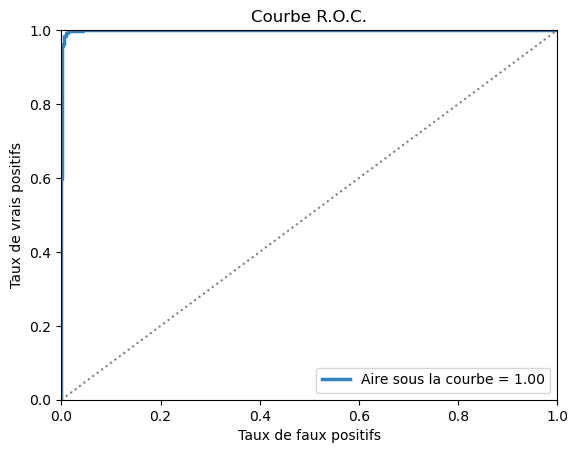

In [1869]:
# Courbe R.O.C.:
fpr, tpr, _ = roc_curve(Billet_df["is_genuine"],Billet_df["proba"])
roc_auc = roc_auc_score(Billet_df["is_genuine"],Billet_df["proba"])

# Graphique:
plt.title("Courbe R.O.C.")
plt.plot(fpr,
        tpr,
        color="#3182bd",
        linewidth=2.5,
        label="Aire sous la courbe = %0.2f" % roc_auc)
plt.plot([0, 1], [0, 1],color="grey", linestyle=":")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend(loc = "lower right")
plt.ylabel("Taux de vrais positifs")
plt.xlabel("Taux de faux positifs")
plt.show()

La courbe de Roc permet de mesurer la performance d'un classificateur binaire.  
elle représente le taux de vrais positifs (sensibilité) en fonction du taux de faux positifs (1 - spécificité) pour différents seuils de classification.
Comme avec les metrics calculées , on trouve un modèle presque parfait avec une aire sous la courbe approximée à 1.

## Prediction sur des donnes inconnues:(Regression logistique)

In [1870]:
# Prediction sur des donnes inconnues:
Billet_test_df =pd.read_csv('billets_production.csv', sep=",")
print(Billet_test_df)
X_test = Billet_test_df[["height_right","margin_low","margin_up","length"]]
X_test = sm.add_constant(X_test)
Billet_test_df["proba"] = model_reg_log.predict(X_test)
Billet_test_df["y_pred"] = (model_reg_log.predict(X_test) >= 0.5).astype(int)
print(Billet_test_df[["id","proba","y_pred"]])

# Affichage des resultats:
print("\nIndentification des billets:")
for i, k in zip(Billet_test_df["y_pred"],Billet_test_df["id"]):
    if i == 1:
        print("Le billet","{}".format(k),"est vrai")
    else:
        print("Le billet","{}".format(k),"est faux")

   diagonal  height_left  height_right  margin_low  margin_up  length   id
0    171.76       104.01        103.54        5.21       3.30  111.42  A_1
1    171.87       104.17        104.13        6.00       3.31  112.09  A_2
2    172.00       104.58        104.29        4.99       3.39  111.57  A_3
3    172.49       104.55        104.34        4.44       3.03  113.20  A_4
4    171.65       103.63        103.56        3.77       3.16  113.33  A_5
    id     proba  y_pred
0  A_1  0.000041       0
1  A_2  0.000003       0
2  A_3  0.000019       0
3  A_4  0.996708       1
4  A_5  0.999988       1

Indentification des billets:
Le billet A_1 est faux
Le billet A_2 est faux
Le billet A_3 est faux
Le billet A_4 est vrai
Le billet A_5 est vrai


# K-Means

Le k-means est un algorithme de clustering qui permet de regrouper des données similaires en un certain nombre de clusters. Dans le cas d'une classification binaire, on peut utiliser le k-means pour diviser les données en deux clusters distincts.

/Users/bahia/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


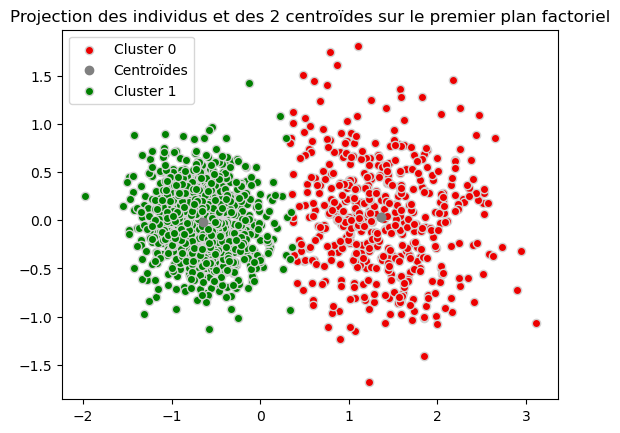

In [1871]:

n_clust = 2

# Clustering 
km = KMeans(n_clusters=n_clust,random_state=42,init="k-means++")
x_km = km.fit_transform(Billet_df[["diagonal","height_left","height_right","margin_low","margin_up","length"]])

# Ajout d'une colonne contenant le cluster attribue:
clusters_km = km.labels_
centroids_km = km.cluster_centers_
#Billet_df["labels"] = km.labels_
#display(Billet_df[:50])
# Clustering par projection des individus sur le premier plan factoriel:
pca_km = decomposition.PCA(n_components="mle").fit(Billet_df[["diagonal","height_left","height_right","margin_low","margin_up","length"]])
acp_km = PCA(n_components=3).fit_transform(Billet_df[["diagonal","height_left","height_right","margin_low","margin_up","length"]])
centroids_km_projected = pca_km.transform(centroids_km) 

# Graphique:
for couleur,k in zip(["#ed0000","#008000"],[0,1]):
    plt.scatter(acp_km[km.labels_==k,0],acp_km[km.labels_==k,1],c=couleur,edgecolors="#D3D3D3",label="Cluster {}".format(k))
    plt.legend()
    plt.scatter(centroids_km_projected[:,0],centroids_km_projected[:,1],color="grey",label="Centroïdes")
plt.title("Projection des individus et des {} centroïdes sur le premier plan factoriel".format(len(centroids_km)))
plt.show()



Text(0.5, 1.0, 'Matrice de confusion K-means\n')

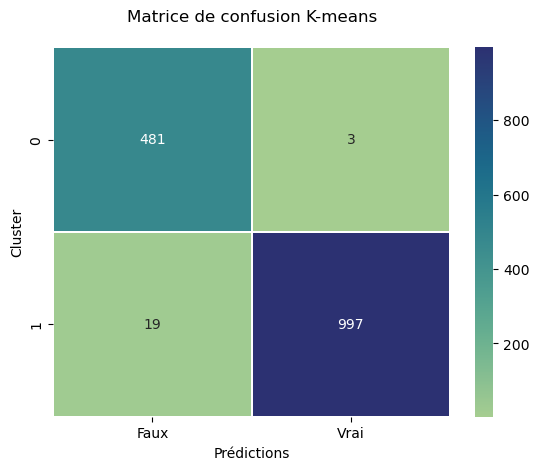

In [1872]:
#Verrification de la classification: Matrice de confusion:
km_matrix = pd.crosstab(clusters_km,Billet_df["is_genuine"])

# Graphique:
sns.heatmap(km_matrix,
            annot = True,
            fmt = ".3g", 
            cmap = sns.color_palette("crest", as_cmap=True),
            linecolor = "white",
            linewidths = 0.3,
            xticklabels = ["Faux","Vrai"],
            yticklabels=["0","1"]
            )
plt.xlabel("Prédictions")
plt.ylabel("Cluster")
plt.title("Matrice de confusion K-means\n")


La classification par k-means est moins precise que celle effectué avec la regression logistique.  
sur les 500 faux billets 19 ont étés predit comme vrais.  
sur les 1000 vrais billets 2 ont étés considérés comme faux

## Predictions sur des donnees inconnues (k_means)

In [1873]:
# Predictions sur des donnees inconnues:
x_test_km = Billet_test_df[["diagonal","height_left","height_right","margin_low","margin_up","length"]]

Billet_test_df["cluster_pred"] = km.predict(x_test_km)
print(Billet_test_df[["id","cluster_pred"]])
print(Billet_test_df)

    id  cluster_pred
0  A_1             0
1  A_2             0
2  A_3             0
3  A_4             1
4  A_5             1
   diagonal  height_left  height_right  margin_low  margin_up  length   id  \
0    171.76       104.01        103.54        5.21       3.30  111.42  A_1   
1    171.87       104.17        104.13        6.00       3.31  112.09  A_2   
2    172.00       104.58        104.29        4.99       3.39  111.57  A_3   
3    172.49       104.55        104.34        4.44       3.03  113.20  A_4   
4    171.65       103.63        103.56        3.77       3.16  113.33  A_5   

      proba  y_pred  cluster_pred  
0  0.000041       0             0  
1  0.000003       0             0  
2  0.000019       0             0  
3  0.996708       1             1  
4  0.999988       1             1  


/Users/bahia/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Representation des billets')

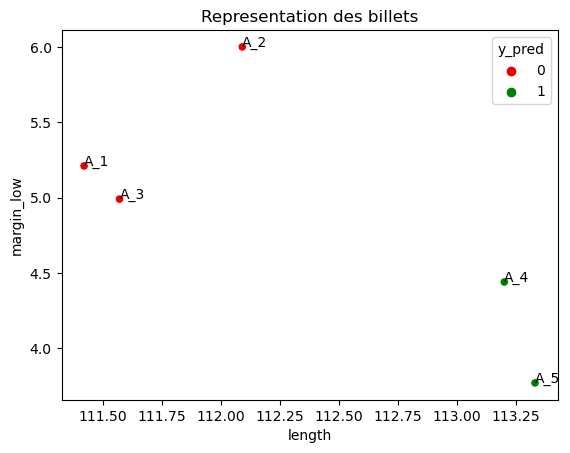

In [1874]:
# Affichage des résultats : scatterplot

couleur = ["#ed0000","#008000"]
sns.scatterplot(Billet_test_df['length'], 
                Billet_test_df['margin_low'], 
                hue=Billet_test_df['y_pred'], 
              legend='auto',palette=couleur)

# affichage de l'id des billets sur le graphique
for i in range(Billet_test_df.shape[0]):
    plt.text(x=Billet_test_df.length[i],y=Billet_test_df.margin_low[i], s=Billet_test_df.id[i], 
          fontdict=dict(color='black',size=10))


plt.title("Representation des billets")
          

In [1875]:

# On supprime les colonnes devenues inutiles:
Billet_df = Billet_df.drop(["proba", "y_pred"], axis=1)

# Sauvegarde fichier Billet_df complete 
Billet_df.to_csv("billet_complet.csv")